## Image Loading, Validation and Preprocessing:

1. Load images from dataset.
2. Preprocess images by resizing, normalizing, and handling imbalanced data to improve model performance and generalization.
3. Apply ImageDataGenerator to artificially increase the diversity of your training data 

In [17]:
# !pip install scikit-learn
# !pip list
# !pip install tflite
# !pip install Pillow
# !pip install tensorflow

In [2]:
from PIL import Image
import numpy as np
import tensorflow as tf
import keras
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.executable
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy
from sklearn.utils import class_weight
from sklearn.utils import compute_class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import cv2


In [3]:
# data\test
sys.executable

'C:\\Users\\ASUS\\anaconda3\\python.exe'

In [5]:
# See class names based on the subdirectories in the training directory
train_path="data/train"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory( 
    train_path,
    seed=2509,
    image_size=(224, 224), # Resize
    batch_size=36,
)

val_path="data/validation"
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=2509,
    image_size=(224, 224), # Resize
    shuffle=False,
    batch_size=36,
)


class_names = sorted(os.listdir(train_path))

# Initialize label counts
label_counts = {class_name: 0 for class_name in class_names}

# Count the images per class
for images, labels in train_dataset:
    for label in labels.numpy():
        class_name = class_names[label]
        label_counts[class_name] += 1

counter = 0
# Print the class names and label counts
for class_name, count in label_counts.items():
    counter += 1
    print(counter)
    print("Class {}: {} images".format(class_name, count))


Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
1
Class apple: 68 images
2
Class banana: 75 images
3
Class beetroot: 88 images
4
Class bell pepper: 90 images
5
Class cabbage: 92 images
6
Class capsicum: 89 images
7
Class carrot: 82 images
8
Class cauliflower: 79 images
9
Class chilli pepper: 87 images
10
Class corn: 87 images
11
Class cucumber: 94 images
12
Class eggplant: 84 images
13
Class garlic: 92 images
14
Class ginger: 68 images
15
Class grapes: 100 images
16
Class jalepeno: 88 images
17
Class kiwi: 88 images
18
Class lemon: 82 images
19
Class lettuce: 97 images
20
Class mango: 86 images
21
Class onion: 94 images
22
Class orange: 69 images
23
Class paprika: 83 images
24
Class pear: 89 images
25
Class peas: 100 images
26
Class pineapple: 99 images
27
Class pomegranate: 79 images
28
Class potato: 77 images
29
Class raddish: 81 images
30
Class soy beans: 97 images
31
Class spinach: 97 images
32
Class sweetcorn: 91 images
33
Class sweetpotato: 69 i

## Create labels.txt for android integration

In [15]:
def recreate_labels():
  labels = [folder for folder in os.listdir(train_path)]
  with open('labels.txt', 'w') as file:
    for label in labels:
      file.write(label)
      file.write('\n')

recreate_labels()   


In [13]:
# labels = [folder for folder in os.listdir(train_path)]
# print(labels) 

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


## Data Preprocessing

In [13]:
def preprocess_images(image_paths, target_size=(224, 224)):
    # OpenCV to load and preprocess the images
    images = [cv2.imread(image_path) for image_path in image_paths]

    # empty list to store the preprocessed images
    preprocessed_images = []

    # ensure images have the same dimensions
    for image in images:
        resized_image = cv2.resize(image, target_size)
        normalized_image = resized_image / 255.0  # Normalize pixel values to [0, 1]
        preprocessed_images.append(normalized_image)

    # convert the list of preprocessed images into a NumPy array
    preprocessed_images = np.array(preprocessed_images)

    # Convert the NumPy array to a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices(preprocessed_images)

    return dataset


In [46]:
# handle imbalanced classes with weights

def apply_class_weights(x, y, w):
    class_weight = tf.gather(class_weights, y)
    return x, y, class_weight

def normalize_image(image, label):
    normalized_image = image / 255.0  # Normalize pixel values to [0, 1]
    return normalized_image, label

def normalize_image(image, label, value):
    normalized_image = tf.image.per_image_standardization(image)
    return normalized_image, label, value

def prepare_batch(x, y, w):
    return x, tf.cast(y, tf.int64), w


In [37]:
# Preparing labels and computing class weights
labels = np.concatenate([y.numpy() for _, y in train_dataset], axis=0)
unique_labels = np.unique(labels)
updated_class_names = [label for label in unique_labels]
class_weights = compute_class_weight('balanced', classes=updated_class_names, y=labels)

# Normalize training data
normalized_balanced_train_dataset = augmented_train_dataset.map(normalize_image)

In [72]:
# Convert labels to integer type and sample_weights to float32
train_batches = normalized_balanced_train_dataset.map(prepare_batch)

# Apply class weights to each batch
normalized_balanced_train_dataset = train_batches.map(apply_class_weights)

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Define the data augmentation Sequential model
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

# Define a function to apply data augmentation to an element (image, label, class weight)
def augment_data(image, label, class_weight):
    augmented_image = img_augmentation(image)
    return augmented_image, label, class_weight

# Apply data augmentation to your normalized and balanced dataset
augmented_normalized_balanced_train_dataset = normalized_balanced_train_dataset.map(augment_data)

In [27]:
def show_post_processed(tf_dataset):
    data_iterator = iter(tf_dataset)

    # Display a few preprocessed images
    num_images_to_display =len(tf_dataset)

    for _ in range(num_images_to_display):
        preprocessed_image = next(data_iterator).numpy()
        plt.imshow(preprocessed_image)
        plt.axis('off')  # Turn off axis labels and ticks
        plt.show()
        
def show_random_images(tf_dataset, num_images=5):
    data_iterator = iter(tf_dataset)
    
    # Randomly select and display num_images images
    random_indices = random.sample(range(len(tf_dataset)), num_images)
    
    for idx in random_indices:
        image, _, _ = next(data_iterator)  # Extract the image from the tuple
        plt.imshow(image[0].numpy())  # Display the first image in the batch
        plt.axis('off')  # Turn off axis labels and ticks
        plt.show()

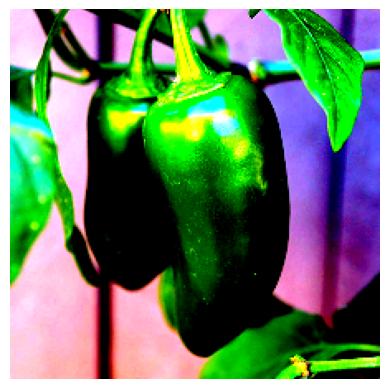

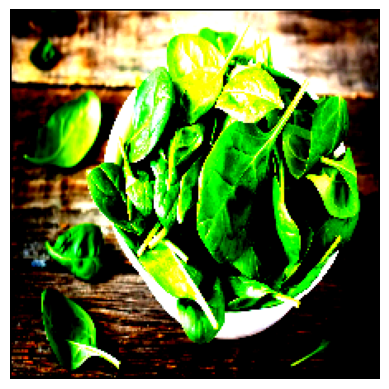

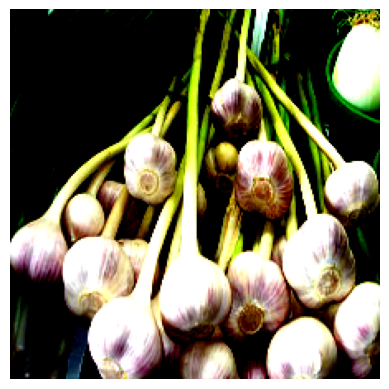

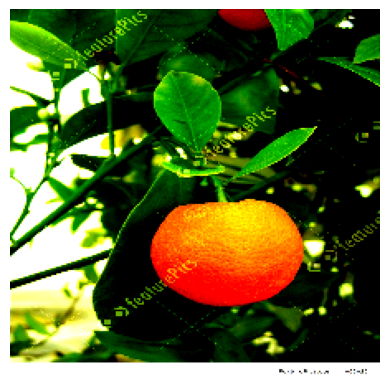

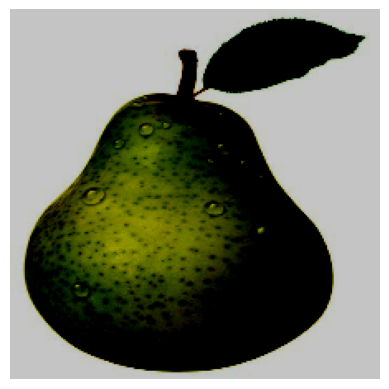

In [96]:
# Show 5 random images from the normalized_augmented_train_dataset
show_random_images(normalized_balanced_train_dataset, num_images=5)

## Apply EfficientNet-Lite model

In [89]:
# check batch shape
# for batch_images, batch_labels, batch_weights in train_batches.take(5):
#     print("Batch Labels Shape:", batch_labels.shape)
#     print("Batch Weights Shape:", batch_weights.shape)
#     unique_classes = np.unique(batch_labels.numpy())
#     print("Unique Classes:", unique_classes)
#     print("Number of Unique Classes:", len(unique_classes))


In [88]:
for batch_images, batch_labels, batch_weights in augmented_normalized_balanced_train_dataset.take(5):
    print("Batch Labels Shape:", batch_labels.shape)
    print("Batch Weights Shape:", batch_weights.shape)
    unique_classes = np.unique(batch_labels.numpy())
    print("Unique Classes:", unique_classes)
    print("Number of Unique Classes:", len(unique_classes))

Batch Labels Shape: (36,)
Batch Weights Shape: (36,)
Unique Classes: [ 1  3  4  6 10 11 12 15 16 17 20 21 24 25 26 29 30 32 33 34]
Number of Unique Classes: 20
Batch Labels Shape: (36,)
Batch Weights Shape: (36,)
Unique Classes: [ 0  2  3  4  6  7  8  9 11 13 14 15 18 19 20 21 22 24 25 27 28 30 31 33
 34 35]
Number of Unique Classes: 26
Batch Labels Shape: (36,)
Batch Weights Shape: (36,)
Unique Classes: [ 0  2  3  5  7  8  9 11 12 13 15 16 17 19 22 24 26 27 30 31 34]
Number of Unique Classes: 21
Batch Labels Shape: (36,)
Batch Weights Shape: (36,)
Unique Classes: [ 0  1  3  4  5  7  8 11 12 14 15 18 19 21 22 23 25 26 27 29 32 33]
Number of Unique Classes: 22
Batch Labels Shape: (36,)
Batch Weights Shape: (36,)
Unique Classes: [ 0  2  5  8  9 10 11 13 15 18 19 20 21 22 23 24 26 28 29 30 32 33 34 35]
Number of Unique Classes: 24


In [8]:
#  building EfficientNetB0 model
input_shape = (224, 224, 3)
num_classes = 36

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output

# reshape the output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

 y)                                                                  'block2a_se_expand[0][0]']   
                                                                                                  
 block2a_project_conv (Conv  (None, 56, 56, 24)           2304      ['block2a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block2a_project_bn (BatchN  (None, 56, 56, 24)           96        ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_expand_conv (Conv2  (None, 56, 56, 144)          3456      ['block2a_project_bn[0][0]']  
 D)                                                                                               
          

                                                                                                  
 block3a_project_conv (Conv  (None, 28, 28, 40)           5760      ['block3a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block3a_project_bn (BatchN  (None, 28, 28, 40)           160       ['block3a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_expand_conv (Conv2  (None, 28, 28, 240)          9600      ['block3a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block3b_e

 block4a_project_conv (Conv  (None, 14, 14, 80)           19200     ['block4a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block4a_project_bn (BatchN  (None, 14, 14, 80)           320       ['block4a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_expand_conv (Conv2  (None, 14, 14, 480)          38400     ['block4a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block4b_expand_bn (BatchNo  (None, 14, 14, 480)          1920      ['block4b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block4c_drop (Dropout)      (None, 14, 14, 80)           0         ['block4c_project_bn[0][0]']  
                                                                                                  
 block4c_add (Add)           (None, 14, 14, 80)           0         ['block4c_drop[0][0]',        
                                                                     'block4b_add[0][0]']         
                                                                                                  
 block5a_expand_conv (Conv2  (None, 14, 14, 480)          38400     ['block4c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5a_e

 block5b_add (Add)           (None, 14, 14, 112)          0         ['block5b_drop[0][0]',        
                                                                     'block5a_project_bn[0][0]']  
                                                                                                  
 block5c_expand_conv (Conv2  (None, 14, 14, 672)          75264     ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_expand_bn (BatchNo  (None, 14, 14, 672)          2688      ['block5c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5c_expand_activation   (None, 14, 14, 672)          0         ['block5c_expand_bn[0][0]']   
 (Activati

 ormalization)                                                                                    
                                                                                                  
 block6b_expand_conv (Conv2  (None, 7, 7, 1152)           221184    ['block6a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block6b_expand_bn (BatchNo  (None, 7, 7, 1152)           4608      ['block6b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6b_expand_activation   (None, 7, 7, 1152)           0         ['block6b_expand_bn[0][0]']   
 (Activation)                                                                                     
          

 block6c_add (Add)           (None, 7, 7, 192)            0         ['block6c_drop[0][0]',        
                                                                     'block6b_add[0][0]']         
                                                                                                  
 block6d_expand_conv (Conv2  (None, 7, 7, 1152)           221184    ['block6c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6d_expand_bn (BatchNo  (None, 7, 7, 1152)           4608      ['block6d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6d_expand_activation   (None, 7, 7, 1152)           0         ['block6d_expand_bn[0][0]']   
 (Activati

                                                                                                  
 top_bn (BatchNormalization  (None, 7, 7, 1280)           5120      ['top_conv[0][0]']            
 )                                                                                                
                                                                                                  
 top_activation (Activation  (None, 7, 7, 1280)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['top_activation[0][0]']      
 GlobalAveragePooling2D)                                                                          
                                                                                                  
 dense (De

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train model
fitted_model = model.fit(train_batches, epochs=10)

Epoch 1/10
87/87 [==============================] - 1048s 11s/step - loss: 1.3508 - accuracy: 0.6196
Epoch 2/10
87/87 [==============================] - 934s 11s/step - loss: 0.5968 - accuracy: 0.8087
Epoch 3/10
87/87 [==============================] - 919s 10s/step - loss: 0.3594 - accuracy: 0.8735
Epoch 4/10
87/87 [==============================] - 970s 11s/step - loss: 0.3465 - accuracy: 0.8844
Epoch 5/10
87/87 [==============================] - 914s 10s/step - loss: 0.2625 - accuracy: 0.9091
Epoch 6/10
87/87 [==============================] - 815s 9s/step - loss: 0.2246 - accuracy: 0.9284
Epoch 7/10
87/87 [==============================] - 1642s 19s/step - loss: 0.2601 - accuracy: 0.9226
Epoch 8/10
87/87 [==============================] - 966s 11s/step - loss: 0.2008 - accuracy: 0.9368
Epoch 9/10
87/87 [==============================] - 1051s 12s/step - loss: 0.1990 - accuracy: 0.9326
Epoch 10/10
87/87 [==============================] - 1831s 21s/step - loss: 0.1640 - accuracy: 0.9

## Model Performance without image augmentation:

A validation loss of 4.74 is relatively high, suggesting that the model's predictions are not very accurate.A lower validation loss is generally better, as it indicates that the model is making better predictions. Validation accuracy represents the percentage of correctly classified examples in the validation dataset. An accuracy of approximately 3.99% is extremely low, indicating that the model is performing poorly

In [12]:
validation_results = model.evaluate(val_dataset)
loss = validation_results[0]
accuracy = validation_results[1]

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

10/10 [==============================] - 45s 3s/step - loss: 4.7420 - accuracy: 0.0399
Validation Loss: 4.741980075836182
Validation Accuracy: 0.03988603875041008


In [57]:
# save model
saved_models_directory = 'Saved_Model'
os.makedirs(saved_models_directory, exist_ok=True)
model.save(os.path.join(saved_models_directory, 'my_model'))

INFO:tensorflow:Assets written to: Saved_Model\my_model\assets


INFO:tensorflow:Assets written to: Saved_Model\my_model\assets


In [67]:
path_to_saved_model = 'Saved_Model/my_model'

# Load the model
model = tf.keras.models.load_model(path_to_saved_model)

# Get a batch of images and labels from the validation dataset
for images, labels in val_dataset:
    break  # Get the first batch

# Use the model to predict labels for the batch of images
predicted_labels = model.predict(images)

# Randomly select 10 examples from the batch
random_indices = random.sample(range(len(images)), 10)

# Print the true and predicted labels
for i, index in enumerate(random_indices):
    true_label = class_names[labels[index].numpy()]  # Convert label index to class name
    predicted_label = class_names[predicted_labels[index].argmax()]  # Get the predicted class name
    
    print(f"Example {i + 1}:")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print()


2/2 [==============================] - 6s 413ms/step
Example 1:
True Label: beetroot
Predicted Label: sweetcorn

Example 2:
True Label: beetroot
Predicted Label: soy beans

Example 3:
True Label: banana
Predicted Label: banana

Example 4:
True Label: banana
Predicted Label: banana

Example 5:
True Label: apple
Predicted Label: banana

Example 6:
True Label: banana
Predicted Label: banana

Example 7:
True Label: banana
Predicted Label: sweetcorn

Example 8:
True Label: bell pepper
Predicted Label: sweetcorn

Example 9:
True Label: bell pepper
Predicted Label: sweetcorn

Example 10:
True Label: beetroot
Predicted Label: sweetcorn



## Model Performance with image augmentation:

A validation loss of 7.33 is higher than before, suggesting that the model's predictions are worse. Validation accuracy of approximately 3% is low, indicating that the model's predictions are far from the actual values.

In [90]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train model
model2 = model.fit(augmented_normalized_balanced_train_dataset, epochs=10)

Epoch 1/10
87/87 [==============================] - 992s 11s/step - loss: 1.1046 - accuracy: 0.6905
Epoch 2/10
87/87 [==============================] - 2095s 24s/step - loss: 0.6825 - accuracy: 0.7823
Epoch 3/10
87/87 [==============================] - 4836s 54s/step - loss: 0.5508 - accuracy: 0.8250
Epoch 4/10
87/87 [==============================] - 925s 11s/step - loss: 0.5081 - accuracy: 0.8334
Epoch 5/10
87/87 [==============================] - 2940s 34s/step - loss: 0.4059 - accuracy: 0.8655
Epoch 6/10
87/87 [==============================] - 2513s 28s/step - loss: 0.4114 - accuracy: 0.8613
Epoch 7/10
87/87 [==============================] - 931s 11s/step - loss: 0.3614 - accuracy: 0.8774
Epoch 8/10
87/87 [==============================] - 2990s 35s/step - loss: 0.3059 - accuracy: 0.9002
Epoch 9/10
87/87 [==============================] - 3244s 37s/step - loss: 0.3026 - accuracy: 0.9021
Epoch 10/10
87/87 [==============================] - 3130s 36s/step - loss: 0.3100 - accuracy:

In [93]:
validation_results = model.evaluate(val_dataset)
loss = validation_results[0]
accuracy = validation_results[1]

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

10/10 [==============================] - 41s 3s/step - loss: 7.3336 - accuracy: 0.0256
Validation Loss: 7.333567142486572
Validation Accuracy: 0.025641025975346565


In [104]:
for images, labels in val_dataset:
    break  # Get the first batch

# Use the model to predict labels for the batch of images
predicted_labels = model.predict(images)

# Randomly select 10 examples from the batch
random_indices = random.sample(range(len(images)), 10)

# Print the true and predicted labels
for i, index in enumerate(random_indices):
    true_label = class_names[labels[index].numpy()]  # Convert label index to class name
    predicted_label = class_names[predicted_labels[index].argmax()]  # Get the predicted class name
    
    print(f"Example {i + 1}:")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print()


2/2 [==============================] - 3s 258ms/step
Example 1:
True Label: apple
Predicted Label: lemon

Example 2:
True Label: apple
Predicted Label: grapes

Example 3:
True Label: beetroot
Predicted Label: pear

Example 4:
True Label: banana
Predicted Label: grapes

Example 5:
True Label: beetroot
Predicted Label: ginger

Example 6:
True Label: apple
Predicted Label: ginger

Example 7:
True Label: bell pepper
Predicted Label: ginger

Example 8:
True Label: beetroot
Predicted Label: grapes

Example 9:
True Label: banana
Predicted Label: grapes

Example 10:
True Label: beetroot
Predicted Label: ginger



## Apply MobileNetV2 model

In [97]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False


9406464/9406464 [==============================] - 2s 0us/step


In [101]:
train_path="data/train"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory( 
    train_path,
    seed=2509,
    image_size=(224, 224), # Resize
    batch_size=36,
)


Found 351 files belonging to 36 classes.


In [ ]:
val_path="data/validation"
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=2509,
    image_size=(224, 224), # Resize
    shuffle=False,
    batch_size=36,
)

In [105]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


Epoch 1/5
87/87 [==============================] - 182s 2s/step - loss: 3.2669 - accuracy: 0.1339 - val_loss: 2.6352 - val_accuracy: 0.2877
Epoch 2/5
87/87 [==============================] - 159s 2s/step - loss: 2.6410 - accuracy: 0.2668 - val_loss: 2.0824 - val_accuracy: 0.4103
Epoch 3/5
87/87 [==============================] - 201s 2s/step - loss: 2.2797 - accuracy: 0.3634 - val_loss: 1.7607 - val_accuracy: 0.5071
Epoch 4/5
87/87 [==============================] - 193s 2s/step - loss: 2.0491 - accuracy: 0.4205 - val_loss: 1.5412 - val_accuracy: 0.5840
Epoch 5/5
87/87 [==============================] - 188s 2s/step - loss: 1.8446 - accuracy: 0.4796 - val_loss: 1.3195 - val_accuracy: 0.6610


## Save the model: 

In [55]:
# save model
saved_models_directory = 'Saved_Model'
os.makedirs(saved_models_directory, exist_ok=True)
model.save(os.path.join(saved_models_directory, 'my_model'))

INFO:tensorflow:Assets written to: Saved_Model\my_model\assets


INFO:tensorflow:Assets written to: Saved_Model\my_model\assets


In [57]:
# path_to_saved_model = 'Saved_Model/my_model'

# # Load the model
# loaded_model = tf.keras.models.load_model(path_to_saved_model)

# # Convert the model to TFLite format
# converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
# tflite_model = converter.convert()

# # Save the TFLite model to a file
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpbovlmcrg\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpbovlmcrg\assets
